In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import as_strided
from scipy.signal import convolve2d

from tf_hog import tf_hog_descriptor

from PIL import Image
%matplotlib inline

plt.rcParams['image.cmap'] = 'viridis'

In [2]:
def read_images(folder):
    fnames = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    images = [np.array(Image.open(os.path.join(folder, f))) for f in fnames]
    return np.array(images)

data = read_images('cifar/')

In [3]:
import numpy as np
import tensorflow as tf
from tf_filters import tf_deriv


def tf_select_by_idx(a, idx):
    return tf.select(tf.equal(idx, 2), 
                     a[:,:,:,2], 
                     tf.select(tf.equal(idx, 1), 
                               a[:,:,:,1], 
                               a[:,:,:,0]))


def tf_hog_descriptor(images, cell_size = 8, block_size = 2, block_stride = 1, n_bins = 9,
                      grayscale = False, oriented = False):

    batch_size, height, width, depth = images.shape
    half_pi = tf.constant(np.pi/2, name="pi_half")
    eps = tf.constant(1e-6, name="eps")
    scale_factor = tf.constant(np.pi * n_bins * 0.99999, name="scale_factor")
    
    img = tf.constant(images, name="ImgBatch", dtype=tf.float32)

    # gradients
    if grayscale:
        gray = tf.image.rgb_to_grayscale(img, name="ImgGray")
        grad = tf_deriv(gray)
    else:
        grad = tf_deriv(img)
    g_x = grad[:,:,:,0::2]
    g_y = grad[:,:,:,1::2]
    
    # maximum norm gradient selection
    g_norm = tf.sqrt(tf.square(g_x) + tf.square(g_y), "GradNorm")
    idx    = tf.argmax(g_norm, 3)
    
    g_norm = tf.expand_dims(tf_select_by_idx(g_norm, idx), -1)
    g_x    = tf.expand_dims(tf_select_by_idx(g_x,    idx), -1)
    g_y    = tf.expand_dims(tf_select_by_idx(g_y,    idx), -1)

    # orientation and binning
    if oriented:
        # atan2 implementation needed 
        # lots of conditional indexing required
        raise NotImplementedError("`oriented` gradient not supported yet")
    else:
        g_dir = tf.atan(g_y / (g_x + eps)) + half_pi
        g_bin = tf.to_int32(g_dir / scale_factor, name="Bins")  

    # cells partitioning
    cell_norm = tf.space_to_depth(g_norm, cell_size, name="GradCells")
    cell_bins = tf.space_to_depth(g_bin,  cell_size, name="BinsCells")

    # cells histograms
    hist = list()
    zero = tf.zeros(cell_bins.get_shape()) 
    for i in range(n_bins):
        mask = tf.equal(cell_bins, tf.constant(i, name="%i"%i))
        hist.append(tf.reduce_sum(tf.select(mask, cell_norm, zero), 3))
    hist = tf.transpose(tf.pack(hist), [1,2,3,0], name="Hist")

    # blocks partitioning
    block_hist = tf.extract_image_patches(hist, 
                                          ksizes  = [1, block_size, block_size, 1], 
                                          strides = [1, block_stride, block_stride, 1], 
                                          rates   = [1, 1, 1, 1], 
                                          padding = 'VALID',
                                          name    = "BlockHist")

    # block normalization
    block_hist = tf.nn.l2_normalize(block_hist, 3, epsilon=1.0)
    
    # HOG descriptor
    hog_descriptor = tf.reshape(block_hist, 
                                [int(block_hist.get_shape()[0]), 
                                     int(block_hist.get_shape()[1]) * \
                                     int(block_hist.get_shape()[2]) * \
                                     int(block_hist.get_shape()[3])], 
                                 name='HOGDescriptor')

    return hog_descriptor

In [4]:
import time

tf.reset_default_graph()
init_op = tf.initialize_all_variables()
X = np.repeat(np.repeat(data[:10000], 4, axis=1), 2, axis=2)

t1 = time.time()
hog = tf_hog_descriptor(X)
with tf.Session() as sess:
    summary_writer = tf.train.SummaryWriter('tf_logs/', sess.graph)
    sess.run(init_op)
    t2 = time.time()
    g = hog.eval()
    print(g.shape)
t3 = time.time()

print('Total time: %.3f sec' % (t3 - t1))
print('Session management time: %.3f sec' % (t2 - t1))
print('Evaluation time: %.3f' % (t3 - t2))

(10000, 3780)
Total time: 131.022 sec
Session management time: 11.220 sec
Evaluation time: 119.803


In [6]:
10000 / 119

84.03361344537815

(Dimension(1), Dimension(32), Dimension(32), Dimension(3))


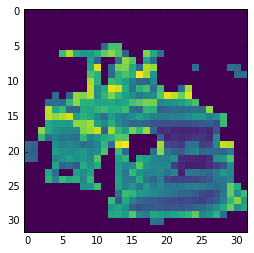

In [80]:
cell_size = 16
block_size = 16
n_bins = 9

a = tf.constant(data[1:2], dtype=tf.float32) 
b = tf.select(tf.less(a, 128), a, tf.zeros(a.get_shape()))
b = tf.reduce_sum(b, 3)


init_op = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init_op)
    z = b.eval()  
    print(a.get_shape())
    plt.figure(figsize=(16,4))
    plt.imshow(z[0,:,:], interpolation='nearest')
    #print(z)

In [3]:
def hog_tensor_fold(img, block_size = 16, cell_size = 8, stride = 8):    
    size_t   = a.dtype.itemsize    
    n_block  = block_size
    n_cell   = cell_size
    n_stride = stride
    n_batch, n_height, n_width, n_channel = img.shape
    
    if (n_width - n_block) % n_stride != 0:
        raise ValueError("`img.shape[2] - block_size` must be a multiple of `stride`")
    if (n_height - n_block) % n_stride != 0:
        raise ValueError("`img.shape[1] - block_size` must be a multiple of `stride`")
    if n_block % n_cell != 0:
        raise ValueError("`block_size` must be a multiple of `cell_size`")
    
    strides = ( n_channel * n_height * n_width * size_t, # batch dimension
                n_channel * n_stride * n_width * size_t, # block Y dimension   within an image
                n_channel * n_stride * size_t,           # block X dimension   within an image
                n_channel * n_cell * n_width * size_t,   # cell Y dimension    within a block
                n_channel * n_cell * size_t,             # cell X dimension    within a block
                n_channel * n_width  * size_t,           # spatial Y dimension within a cell
                n_channel * size_t,                      # spatial X dimension within a cell
                size_t )                                 # channel dimension
    
    shape   = ( n_batch, 
               (n_height - n_block) // n_stride + 1, 
                n_width // n_stride, 
                n_block // n_cell, 
                n_block // n_cell, 
                n_cell,
                n_cell,
                n_channel )
    
    result = as_strided(img, strides=strides, shape=shape)
    result = result[:, :, :(n_width - n_block)//n_stride + 1, :, :, :]
    result = result.reshape((result.shape[0],
                             result.shape[1]*result.shape[2],
                             result.shape[3]*result.shape[4],
                             result.shape[5],
                             result.shape[6],
                             result.shape[7]))
    
    return result

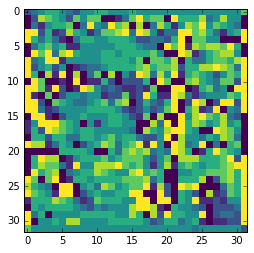

In [213]:
# numpy code

grayscale = False
oriented = False
n_bins = 9

k = 6
X = data[:10]
kernel = np.array([[1,0,-1]])

if grayscale:
    img = X[k].mean(axis=2)    
    gx = convolve2d(img, kernel,   mode = 'same')
    gy = convolve2d(img, kernel.T, mode = 'same')   
    g_mag = np.sqrt(gx**2 + gy**2)
    
else:
    img = X[k]
    gx = np.stack([convolve2d(img[:,:,0], kernel,   mode = 'same'),
                   convolve2d(img[:,:,1], kernel,   mode = 'same'),
                   convolve2d(img[:,:,2], kernel,   mode = 'same')], axis=-1)
    
    gy = np.stack([convolve2d(img[:,:,0], kernel.T, mode = 'same'),
                   convolve2d(img[:,:,1], kernel.T, mode = 'same'),
                   convolve2d(img[:,:,2], kernel.T, mode = 'same')], axis=-1)
    
    g_mag = np.sqrt(gx**2 + gy**2)
    ch_idx = np.argmax(g_mag, axis = 2)
    row_idx, col_idx = np.indices((g_mag.shape[0], g_mag.shape[1]))
    
    gx = gx[row_idx, col_idx, ch_idx]
    gy = gy[row_idx, col_idx, ch_idx]
    g_mag = g_mag[row_idx, col_idx, ch_idx]

g_dir = np.arctan2(gy, gx)
if oriented:
    g_dir += np.pi
    g_bin = np.floor(g_dir / np.pi * n_bins * 0.4999999)
else:
    g_dir[g_dir < 0] += np.pi
    g_bin = np.floor(g_dir / np.pi * n_bins * 0.99999)
    
g_bin = g_bin.reshape(g_bin.shape[0], g_bin.shape[1], -1)

plt.imshow(g_bin[:,:,0], interpolation='nearest')

In [ ]:
Z.shape

In [ ]:
X[0,:,:,0]